Datos cargados exitosamente.
Vectores promedio de Word2Vec:
[[ 0.00017117 -0.00023709  0.00101066 ...  0.00053264 -0.00170498
  -0.00023669]
 [-0.00340243  0.00443886 -0.00316347 ... -0.00335237  0.00099146
   0.00302364]
 [-0.0067749   0.0021796  -0.00262231 ... -0.00672233 -0.00997708
   0.00724622]
 ...
 [-0.00203047  0.00084168  0.00073573 ... -0.00206656 -0.00529526
  -0.00232061]
 [ 0.00070065 -0.00098148  0.00109488 ... -0.00133838  0.00067744
  -0.00143426]
 [-0.00234498 -0.00299736 -0.00030339 ... -0.00126365  0.00147225
   0.00182848]]


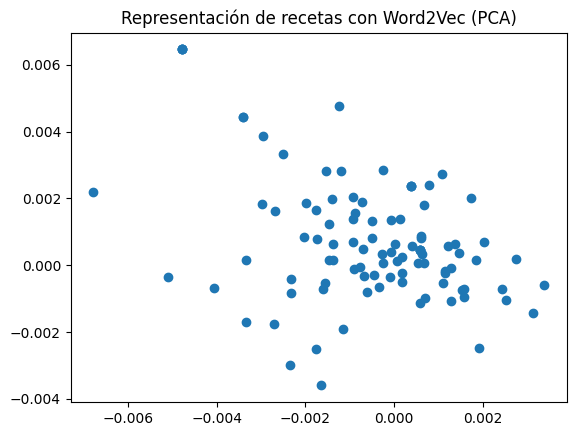

KNN Regressor MSE: 1.60546875
Epoch [10/100], Loss: 2.6455740928649902
Epoch [20/100], Loss: 0.7152408957481384
Epoch [30/100], Loss: 0.46254032850265503
Epoch [40/100], Loss: 0.25010472536087036
Epoch [50/100], Loss: 0.1715797632932663
Epoch [60/100], Loss: 0.14590702950954437
Epoch [70/100], Loss: 0.13737744092941284
Epoch [80/100], Loss: 0.13393943011760712
Epoch [90/100], Loss: 0.13290996849536896
Epoch [100/100], Loss: 0.13241912424564362
Neural Network MSE: 1.793273687362671


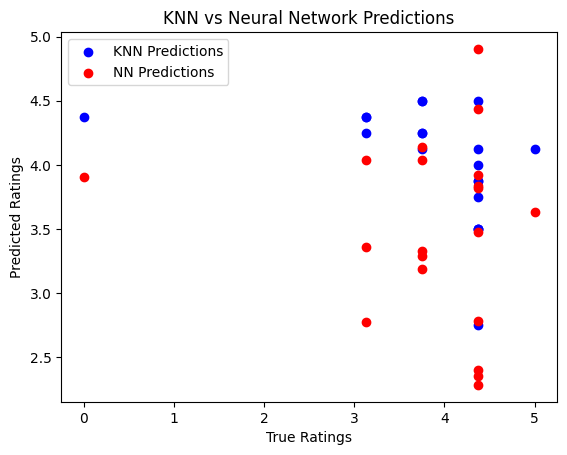

In [30]:
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Inicializar spaCy
nlp = spacy.load("en_core_web_sm")


# Cargar el modelo BERT y el tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Asegurarse de que el modelo esté en modo de evaluación
model.eval()

# Ruta al archivo JSON (ajusta el path según donde esté ubicado el archivo)
path_file = "full_format_recipes.json"

# Cargar el archivo JSON como un DataFrame de Pandas
def load_recipes(file_path):
    try:
        with open(file_path, "r") as file:
            recipes_df = pd.read_json(file)
            recipes_df.dropna(inplace=True)
            print("Datos cargados exitosamente.")
            return recipes_df
    except ValueError as e:
        print(f"Error al leer el archivo JSON: {e}")
        return None

def preprocess_text_spacy(text):
    """
    Preprocesa el texto usando SpaCy:
    - Elimina caracteres no alfabéticos
    - Realiza tokenización y lematización
    """
    # Eliminar caracteres no alfabéticos
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Procesar el texto con SpaCy
    doc = nlp(text)

    # Tokenización y Lematización con SpaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    text_lemma = ' '.join(tokens)

    # Convertimos el texto en una lista de tokens
    words = re.findall(r'\S+', text_lemma)

    # Devolver el texto procesado como lista de palabras
    return words

def compute_tfidf(docs):
    """
    Calcula la representación TF-IDF de los documentos.
    :param docs: Lista de documentos como texto
    :return: Matriz TF-IDF y el vectorizador
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)
    return tfidf_matrix, vectorizer

def compute_word2vec(docs):
    """
    Calcula la representación vectorial de documentos usando Word2Vec.
    :param docs: Lista de documentos como texto
    :return: Lista de vectores promediados para cada documento
    """
    # Tokenización de documentos
    tokenized_docs = [doc.split() for doc in docs]

    # Entrenamiento de Word2Vec
    model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

    # Calcular promedio de embeddings para cada documento
    doc_vectors = []
    for tokens in tokenized_docs:
        word_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if word_vectors:
            doc_vectors.append(np.mean(word_vectors, axis=0))
        else:
            doc_vectors.append(np.zeros(model.vector_size))

    return np.array(doc_vectors), model
def compute_bert_embeddings(docs):
    """
    Calcula los embeddings de BERT para cada documento.
    :param docs: Lista de documentos como texto
    :return: Lista de embeddings de documentos
    """
    embeddings = []

    for doc in docs:
        # Tokenizar el documento
        inputs = tokenizer(doc, return_tensors="pt", truncation=True, padding=True, max_length=512)


        # Pasar los tokens por BERT
        with torch.no_grad():  # No necesitamos gradientes para la inferencia
            outputs = model(**inputs)

        # Extraer los embeddings de la ´ultima capa oculta
        last_hidden_states = outputs.last_hidden_state

        # Tomamos la representación del token [CLS] (primer token)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

        embeddings.append(cls_embedding)

    return np.array(embeddings)

# Cargar recetas
recipes_df = load_recipes(path_file)

# Tomar una muestra de las primeras 20 filas para prueba
recipes_df = recipes_df.iloc[0:100, :]

# Obtener la columna 'desc' (descripción de las recetas)
text_to_process = recipes_df.loc[:, "desc"]
ratings = recipes_df.loc[:, "rating"]

# Aplicar el preprocesamiento de texto a cada descripción
processed_words = text_to_process.apply(preprocess_text_spacy)

# Convertir la lista de palabras procesadas a un formato adecuado para TF-IDF y Word2Vec (como lista de strings)
processed_docs = [' '.join(words) for words in processed_words]

# 1. Aplicar TF-IDF
tfidf_matrix, vectorizer = compute_tfidf(processed_docs)

terms = vectorizer.get_feature_names_out()
matrix=tfidf_matrix.toarray()


"""
print("Terminos")
print(terms)
print("Matriz TF-IDF:")
for i, doc in enumerate(matrix):
    print(i)
    print(f"recipe {i+1}: {doc}")
"""

# 2. Aplicar Word2Vec
word2vec_vectors, word2vec_model = compute_word2vec(processed_docs)
print("Vectores promedio de Word2Vec:")
print(word2vec_vectors)

plt.figure(2)
# Plotear los vectores
plt.scatter(word2vec_vectors[:, 0], word2vec_vectors[:, 1])
plt.title("Representación de recetas con Word2Vec (PCA)")
plt.show()

# 3. Aplicar BERT
# Convertir las descripciones a una lista de documentos (sin preprocesar)
processed_docs = text_to_process.tolist()

# Obtener los embeddings de BERT para las descripciones
bert_embeddings = compute_bert_embeddings(processed_docs)

"""
# Mostrar los embeddings de BERT para los primeros 3 documentos
print("Embeddings de BERT:")
print(bert_embeddings[:3])  # Muestra los primeros 3 embeddings
"""



#######################################
#Redes Neuronales utilizando PyTorch
#######################################


import torch.nn as nn
import torch.optim as optim

# 4. Entrenamiento y evaluaci´on de modelos de regresión

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, ratings, test_size=0.2, random_state=42)

# Estandarizar los datos (si es necesario para KNN, ya que KNN depende de las distancias entre puntos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#####
###  Regresor K-NN  ###
#####

def KNN_Regresor(X_train_scaled,X_test_scaled,y_train,n_neighbors=5):

    # Entrenamiento del modelo KNN Regressor
    knn_model = KNeighborsRegressor(n_neighbors)  # Puedes ajustar 'n_neighbors' según sea necesario
    knn_model.fit(X_train_scaled, y_train)

    # Predicción y evaluación del modelo
    y_pred_knn = knn_model.predict(X_test_scaled)

    # Calcular el error cuadrático medio (MSE) para KNN
    mse_knn = mean_squared_error(y_test, y_pred_knn)
    print(f"KNN Regressor MSE: {mse_knn}")
    return y_pred_knn

y_pred_knn=KNN_Regresor(X_train_scaled,X_test_scaled,y_train,n_neighbors=5)

######
###  Regresión_NN con pytorch ###
######
# Definir el modelo de red neuronal
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Capa de entrada
        self.fc2 = nn.Linear(128, 64)  # Capa oculta
        self.fc3 = nn.Linear(64, 1)  # Capa de salida (valor de rating)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Inicializar el modelo
model_nn = RegressionNN(input_size=X_train_scaled.shape[1])

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Entrenamiento de la red neuronal
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model_nn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Predicción y evaluación del modelo
model_nn.eval()  # Poner el modelo en modo evaluación
with torch.no_grad():
    y_pred_nn = model_nn(X_test_tensor)

# Calcular el error cuadrático medio (MSE) para la red neuronal
mse_nn = mean_squared_error(y_test_tensor.numpy(), y_pred_nn.numpy())
print(f"Neural Network MSE: {mse_nn}")


plt.figure(3)
# Visualización de los resultados de la predicción vs los valores reales
plt.scatter(y_test, y_pred_knn, color='blue', label="KNN Predictions")
plt.scatter(y_test, y_pred_nn, color='red', label="NN Predictions")
plt.xlabel("True Ratings")
plt.ylabel("Predicted Ratings")
plt.title("KNN vs Neural Network Predictions")
plt.legend()
plt.show()



In [31]:
############################################################################
####################### EXTENSION ###########################################
######################################################################
from transformers import pipeline
import pandas as pd


# Cargar los pipelines para resumen con tres modelos diferentes
summarizer_bart = pipeline("summarization", model="facebook/bart-large-cnn")
summarizer_t5 = pipeline("summarization", model="t5-small")
summarizer_pegasus = pipeline("summarization", model="google/pegasus-xsum")

# Funciones para resumir las instrucciones
def summarize_instructions_bart(text):
    input_length = len(text.split())
    max_length = min(150, input_length)  # Ajustar max_length según el tamaño del texto
    summary = summarizer_bart(text, max_length=max_length, min_length=50, do_sample=False)
    return summary[0]['summary_text']

def summarize_instructions_t5(text):
    input_length = len(text.split())
    max_length = min(150, input_length)  # Ajustar max_length según el tamaño del texto
    summary = summarizer_t5(text, max_length=max_length, min_length=50, do_sample=False)
    return summary[0]['summary_text']

def summarize_instructions_pegasus(text):
    input_length = len(text.split())
    max_length = min(150, input_length)  # Ajustar max_length según el tamaño del texto
    summary = summarizer_pegasus(text, max_length=max_length, min_length=50, do_sample=False)
    return summary[0]['summary_text']

recipes_df = recipes_df.head(1)

# Resumir las instrucciones para todas las filas del DataFrame
results = []
for index, row in recipes_df.iterrows():
    recipe_directions = row["directions"]

    # Generar resúmenes con cada modelo
    summary_bart = summarize_instructions_bart(' '.join(recipe_directions))
    summary_t5 = summarize_instructions_t5(' '.join(recipe_directions))
    summary_pegasus = summarize_instructions_pegasus(' '.join(recipe_directions))

    results.append({
        'index': index,
        'original': ' '.join(recipe_directions),
        'summary_bart': summary_bart,
        'summary_t5': summary_t5,
        'summary_pegasus': summary_pegasus
    })


# Convertir los resultados a un DataFrame
summary_df = pd.DataFrame(results)


# Mostrar los resultados
print(summary_df)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   index                                           original  \
0      1  Combine first 9 ingredients in heavy medium sa...   

                                        summary_bart  \
0  Pork, eggs, flour and Port and puree. Combine ...   

                                          summary_t5  \
0  heat oil in heavy small skillet over medium-hi...   

                                     summary_pegasus  
0  Adapted from "The Art of French Cooking" by Je...  
